<div style="text-align:center;">
    <h1 style="font-size: 50px; margin: 0px; margin-bottom: 5px;">Maximum Radial Extent Plot</h1>
    <h2 style="margin:0px; margin-bottom: 5px;">COMPAS methods paper Figure 6</h2>
    <p style="text-align:center;">A notebook for reproducing the maximum radial extent plot in the COMPAS methods paper.</p>
</div>

<img src="https://compas.science/images/COMPAS_CasA.png" style="width:50%; display:block; margin:auto; margin-bottom:20px">

In [11]:
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
import astropy.constants as consts
import matplotlib
import astropy.units as u

In [7]:
# make the plots pretty
%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='serif')
fs = 24

params = {'legend.fontsize': fs,
         'axes.labelsize': fs,
         'xtick.labelsize':0.7*fs,
         'ytick.labelsize':0.7*fs}
plt.rcParams.update(params)

# Define the stellar types
First we can make a list of objects that describe the stellar types with labels and colours

In [8]:
stellar_types = [
    None,
    {"long": "Main Sequence", "short": "MS", "colour": None},
    {"long": "Hertzsprung Gap", "short": "HG", "colour": None},
    {"long": "First Giant Branch", "short": "FGB", "colour": None},
    {"long": "Core Helium Burning", "short": "CHeB", "colour": None},
    {"long": "Early Asymptotic Giant Branch", "short": "EAGB", "colour": None},
    {"long": "Thermally Pulsing Asymptotic Giant Branch", "short": "TPAGB", "colour": None},
    {"long": "Helium Main Sequence", "short": "HeMS", "colour": None},
    {"long": "Helium Hertsprung Gap", "short": "HeHG", "colour": None},
    {"long": "Helium Giant Branch", "short": "HeGB", "colour": None},
    {"long": "Helium White Dwarf", "short": "HeWD", "colour": None},
    {"long": "Carbon/Oxygen White Dwarf", "short": "COWD", "colour": None},
    {"long": "Oxygen/Neon White Dwarf", "short": "ONeWD", "colour": None},
    {"long": "Neutron Star", "short": "NS", "colour": "grey"},
    {"long": "Black Hole", "short": "BH", "colour": "black"},
    {"long": "Massless Remnant", "short": "MR", "colour": "yellow"},
    {"long": "Chemically Homogeneous", "short": "CHE", "colour": "brown"}
]

for i in [1, 2]:
    stellar_types[i]["colour"] = plt.get_cmap("YlOrBr")(0.3 * i)

for i in [3, 4]:
    stellar_types[i]["colour"] = plt.get_cmap("Blues")(0.3 * (i - 2))

for i in [5, 6]:
    stellar_types[i]["colour"] = plt.get_cmap("Greens")(0.3 * (3 - (i - 4)))
    
for i in [7, 8, 9]:
    stellar_types[i]["colour"] = plt.get_cmap("plasma")(0.1 + 0.2 * (i - 7))
    
for i in [10, 11, 12]:
    stellar_types[i]["colour"] = plt.get_cmap("copper")(0.1 + 0.2 * (i - 9))

# Data functions
Functions for getting variables from COMPAS detailed output files and gathering necessary information for maximum radius plots.

In [13]:
def get_detailed_output_vars(compas_file, variables):
    """ Return a list of variables from a COMPAS detailed output file """
    with h5.File(compas_file, "r") as compas:
        var_list = [compas[variables[i]][...].squeeze() for i in range(len(variables))]
    return var_list

In [32]:
def gather_maximum_radius_data(folder, files, max_ev_time=13700.0):
    """ Get the range of masses, corresponding maximum radii as well as R_ZAMS """
    n_masses = len(files)
    masses = np.zeros(n_masses)
    R_ZAMS = np.zeros(n_masses)
    maximum_radius = np.zeros((len(stellar_types) - 1, n_masses))
    for i in range(len(files)):
        file_path = "{}/Detailed_Output/BSE_Detailed_Output_{}.h5".format(folder, files[i])
        m_1, time, stellar_type, radius = get_detailed_output_vars(file_path, ["Mass(1)",
                                                                               "Time",
                                                                               "Stellar_Type(1)",
                                                                               "Radius(1)"])
        
        # change MS < 0.7 to just MS
        stellar_type[stellar_type == 0] = 1

        # store the mass
        masses[i] = m_1[0]
        
        # limit evolution time
        time_limit = time < max_ev_time
        stellar_type = stellar_type[time_limit]
        radius = radius[time_limit]
        
        # find maximum radius for each stellar type
        for st in range(1, len(stellar_types)):
            radius_at_st = radius[stellar_type == st]
            if len(radius_at_st) > 0:
                maximum_radius[st - 1][i] = np.max(radius_at_st)
            
            # store ZAMS radius
            if st == 1:
                R_ZAMS[i] = radius_at_st[0]
            
    return masses, maximum_radius, R_ZAMS

In [34]:
max_r_masses, maximum_radius_solar, R_ZAMS_solar = gather_maximum_radius_data("COMPAS_Output", range(500))

In [35]:
max_r_masses, maximum_radius_lowz, R_ZAMS_lowz = gather_maximum_radius_data("COMPAS_Output", range(500, 1000))

# Important transition masses
The following functions give the important transition masses from Hurley+2000

In [40]:
def m_hook(zeta):
    return 1.0185 + 0.16015 * zeta + 0.0892 * zeta**2

def m_helium_flash(zeta):
    return 1.995 + 0.25 * zeta + 0.087 * zeta**2

def m_FGB(Z):
    return (13.048 * (Z / 0.02)**0.06) / (1 + 0.0012 * (0.02 / Z)**1.27)

# Plotting function

In [45]:
def plot_max_R(masses, R_ZAMS, max_R, Z, mass_label_list, mass_label_loc=0.35, zloc=(0.98, 0.02), stellar_type_list=True, fig=None, ax=None, show=True):
    if fig is None or ax is None:
        fig, ax = plt.subplots(1, figsize=(10, 8))

    # plot the ZAMS radius
    ax.plot(masses, R_ZAMS, color="grey", label="ZAMS", lw=2, zorder=10)

    # work out the top of the maximum radius plot
    top = np.maximum(np.maximum(max_R[3], max_R[4]), max_R[5])
    
    # fill the areas of case A,B,C mass transfer
    mask = masses > mass_label_list[0][0]
    ax.fill_between(masses[mask], np.zeros(len(R_ZAMS))[mask], top[mask], color="white", zorder=2)
    ax.fill_between(masses[mask], R_ZAMS[mask], max_R[0][mask], color=stellar_types[1]["colour"], alpha=0.1, zorder=3)
    ax.fill_between(masses[mask], max_R[0][mask], max_R[3][mask], color=stellar_types[2]["colour"], alpha=0.1, zorder=3)
    ax.fill_between(masses[mask], max_R[3][mask], top[mask], color=stellar_types[4]["colour"], alpha=0.1, zorder=3)    
    
    # plot each maximum radius track
    for st in range(1, 10):
        # for most of them only plot the line when it is above its predecessor
        if st < 7:
            mask = max_R[st - 1] > max_R[st - 2]
        # but for Helium stars plot everything
        else:
            mask = np.repeat(True, len(max_R[st - 1]))
        
        ax.plot(masses[mask], max_R[st - 1][mask], color=stellar_types[st]["colour"], label=stellar_types[st]["short"], lw=2, zorder=5)

    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.set_ylabel(r"$R_{\rm max} \ [\rm R_{\odot}]$")
    ax.set_xlabel(r"$M_{\rm ZAMS} \ [\rm M_{\odot}]$")

    ax.set_xlim((np.min(masses), np.max(masses)))

    ax.annotate(r"$Z = {}$".format(Z), xy=zloc, xycoords="axes fraction", ha="right", va="bottom", fontsize=0.7 * fs)

    # add mass limits
    for mass, label in mass_label_list:
        ax.axvline(mass, color="grey", linestyle="dotted", lw=1, zorder=1)
        ax.annotate(label, (mass * 0.98, mass_label_loc), fontsize=0.6 * fs, rotation=90, ha="right", va="top", color="grey")

    # add a stellar type list
    if stellar_type_list:
        spacing = 0.05
        for st in range(1, 10):
            ax.annotate(stellar_types[st]["short"], xy=(1.01, spacing * (10 - st - 0.7)), xycoords="axes fraction", color=stellar_types[st]["colour"], fontsize=0.7*fs, weight="bold")
        ax.annotate("ZAMS", xy=(1.01, spacing * (10 - 0.7)), xycoords="axes fraction", color="grey", fontsize=0.7*fs, weight="bold")

    if show:
        plt.show()
    return fig, ax

# Recreate the plot from the paper

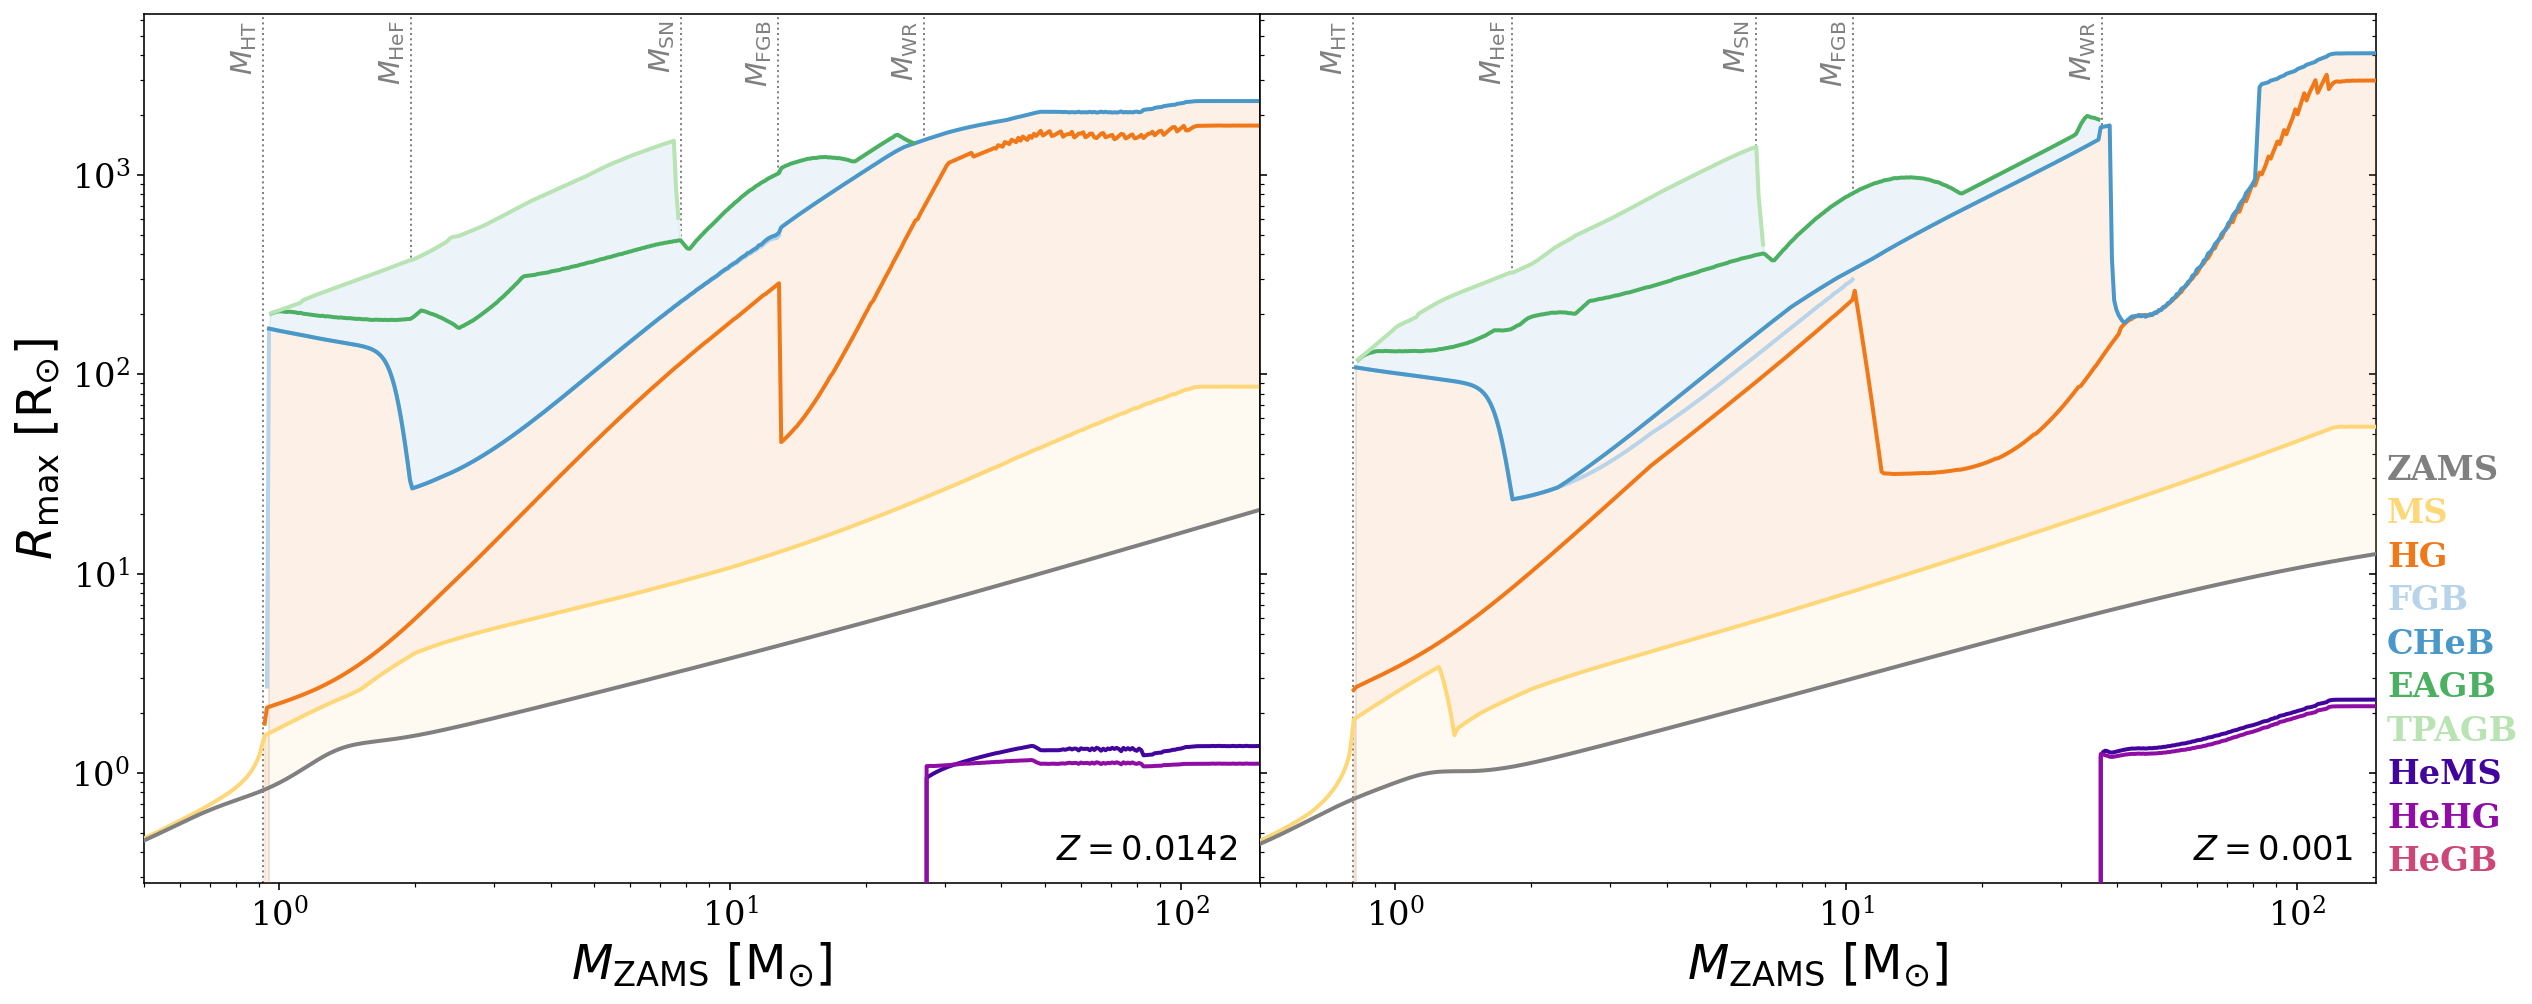

In [121]:
# create a two panel plot
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.subplots_adjust(wspace=0.0)

# make the solar plot (with no stellar type list)
Z = 0.0142
zeta = np.log10(Z / 0.02)
mass_label_list = [(0.92, r"$M_{\rm HT}$"), (m_helium_flash(zeta), r"$M_{\rm HeF}$"), (7.8, r"$M_{\rm SN}$"), (m_FGB(Z), r"$M_{\rm FGB}$"), (27, r"$M_{\rm WR}$")]
plot_max_R(max_r_masses, R_ZAMS_solar, maximum_radius_solar, Z, mass_label_list, mass_label_loc=6e3, zloc=(0.98, 0.02), fig=fig, ax=axes[0], show=False, stellar_type_list=False)

# make the low Z plot (but with a stellar type list)
Z = 0.001
zeta = np.log10(Z / 0.02)
mass_label_list = [(0.804, r"$M_{\rm HT}$"), (m_helium_flash(zeta), r"$M_{\rm HeF}$"), (6.3, r"$M_{\rm SN}$"), (m_FGB(Z), r"$M_{\rm FGB}$"), (37, r"$M_{\rm WR}$")]
plot_max_R(max_r_masses, R_ZAMS_lowz, maximum_radius_lowz, Z, mass_label_list, mass_label_loc=6e3, zloc=(0.98, 0.02), fig=fig, ax=axes[1], show=False)

# make sure the scale is the same
ylims = (np.min([axes[0].get_ylim()[0], axes[1].get_ylim()[0]]),
         np.max([axes[0].get_ylim()[1], axes[1].get_ylim()[1]]))
for ax in axes:
    ax.set_ylim(ylims)
    
# hide the yaxis stuff for the right panel
axes[1].set_axisbelow(False)
axes[1].tick_params(axis="y", which="both", left=True, right=True, direction="in")
# axes[1].tick_params(axis="y", which="both", left=True, right=True)
axes[1].yaxis.set_ticklabels([])
axes[1].set_ylabel("")

# 2.0 0.6, 3.5 0.8

plt.savefig("maximum_radius.pdf", format="pdf", bbox_inches="tight")

plt.show()

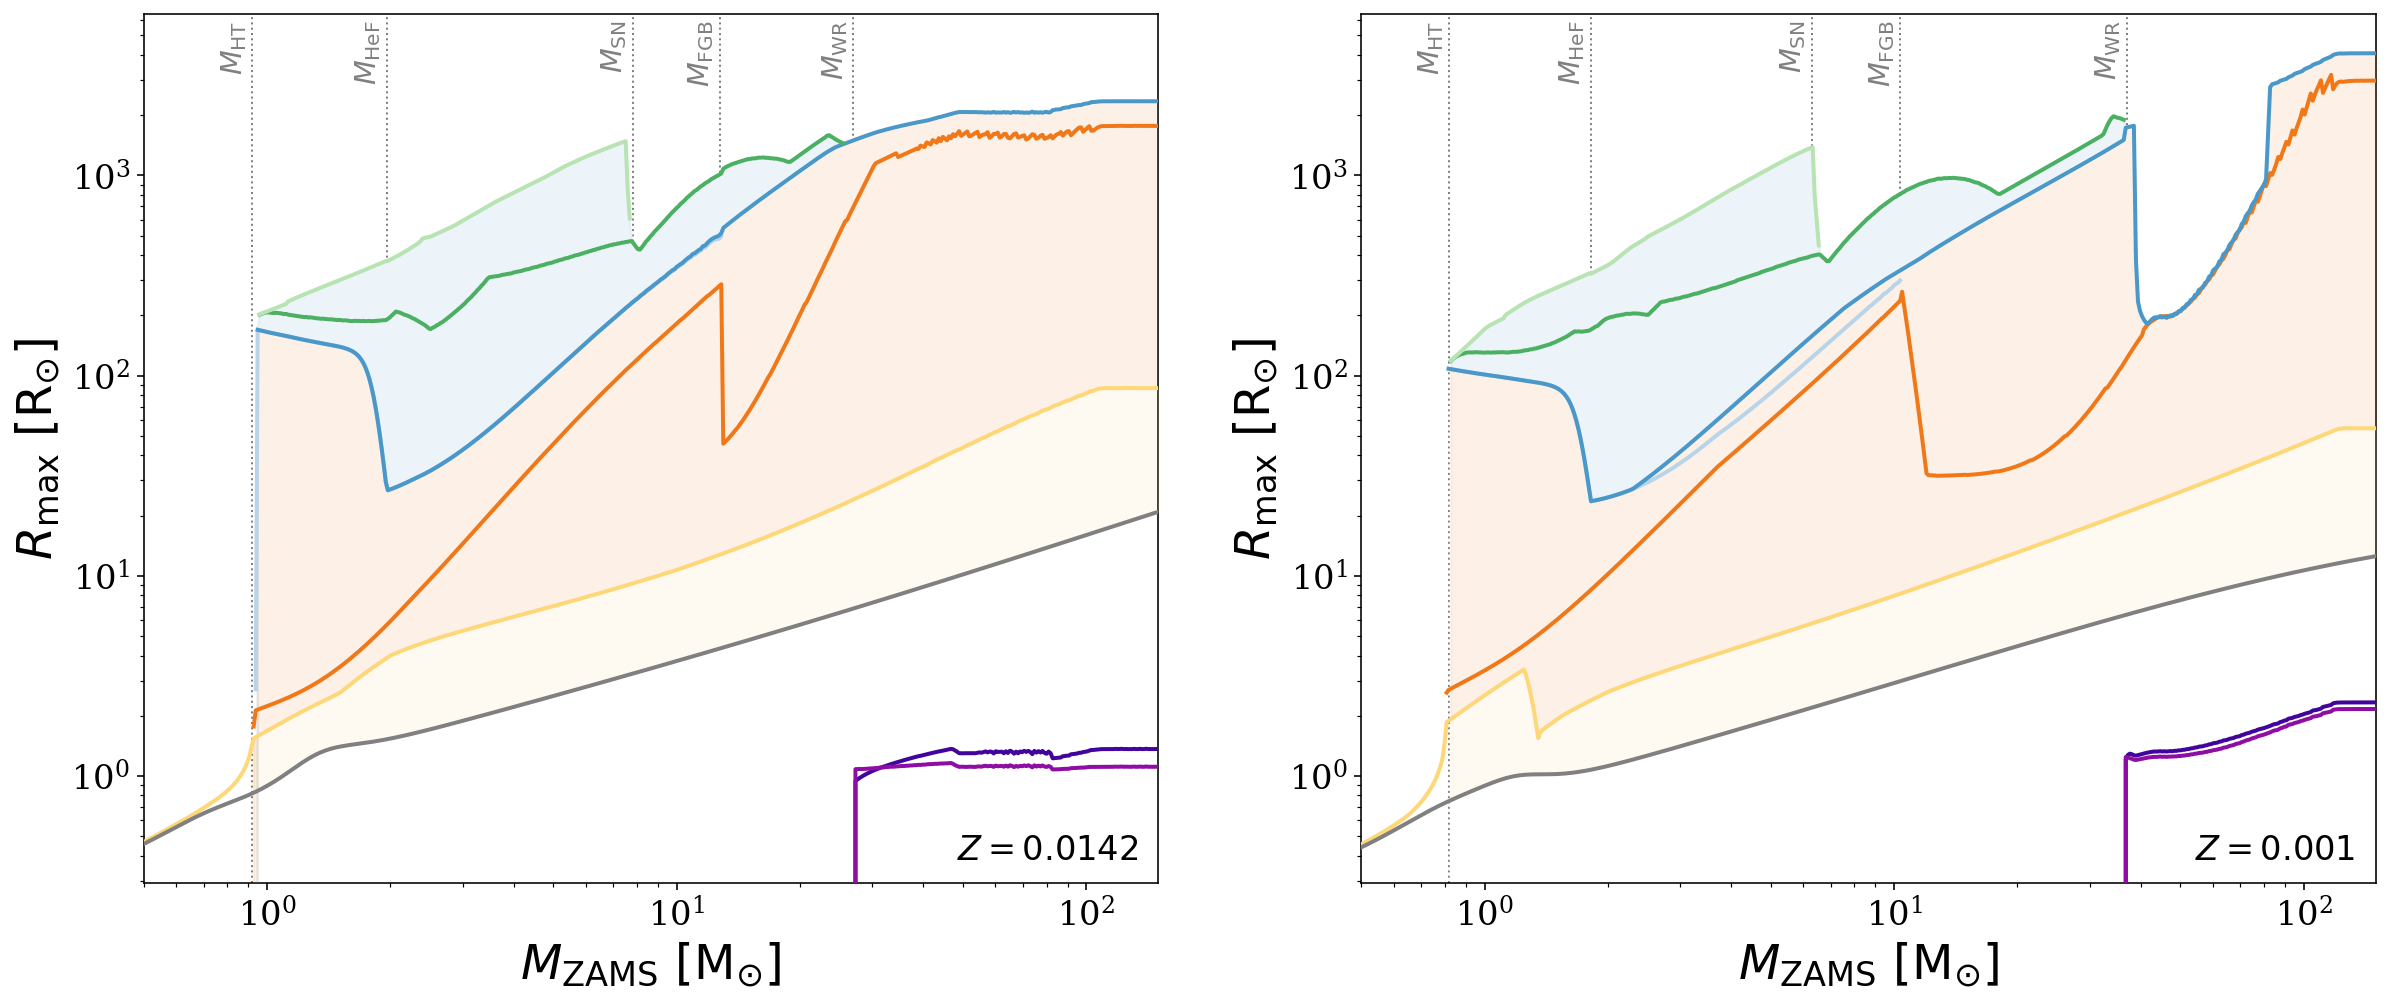

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

Z = 0.0142
zeta = np.log10(Z / 0.02)
mass_label_list = [(0.92, r"$M_{\rm HT}$"), (m_helium_flash(zeta), r"$M_{\rm HeF}$"), (7.8, r"$M_{\rm SN}$"), (m_FGB(Z), r"$M_{\rm FGB}$"), (27, r"$M_{\rm WR}$")]
plot_max_R(max_r_masses, R_ZAMS_solar, maximum_radius_solar, Z, mass_label_list, mass_label_loc=6e3, zloc=(0.98, 0.02), fig=fig, ax=axes[0], show=False, stellar_type_list=False)

Z = 0.001
zeta = np.log10(Z / 0.02)
mass_label_list = [(0.82, r"$M_{\rm HT}$"), (m_helium_flash(zeta), r"$M_{\rm HeF}$"), (6.3, r"$M_{\rm SN}$"), (m_FGB(Z), r"$M_{\rm FGB}$"), (37, r"$M_{\rm WR}$")]
plot_max_R(max_r_masses, R_ZAMS_lowz, maximum_radius_lowz, Z, mass_label_list, mass_label_loc=6e3, zloc=(0.98, 0.02), fig=fig, ax=axes[1], show=False, stellar_type_list=False)

# make sure the scale is the same
ylims = (np.min([axes[0].get_ylim()[0], axes[1].get_ylim()[0]]),
         np.max([axes[0].get_ylim()[1], axes[1].get_ylim()[1]]))
for ax in axes:
    ax.set_ylim(ylims)

axes[1].yaxis.set_tick_params(labelleft=True)



plt.savefig("maximum_radius.pdf", format="pdf", bbox_inches="tight")

plt.show()